In [21]:
import pandas as pd
import numpy as np
from openai import OpenAI
from dotenv import load_dotenv
import json
from tqdm import tqdm

In [22]:
df = pd.read_json("data/mbtibench.jsonl", lines=True)
print(df.shape)
df.head()

(286, 6)


,id,source,annotation,posts,softlabels,hardlabels
0,1,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...",[think that all these situations depend on who...,"{'E/I': 0.806772908366533, 'S/N': 0.1107266435...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'J'}"
1,2,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...",[although I did get a PS1 and 2 and Box360 alo...,"{'E/I': 0.806772908366533, 'S/N': 0.0484429065...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'P'}"
2,3,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...","[dramatic, moving , . do; it's the single h...","{'E/I': 0.806772908366533, 'S/N': 0.4411764705...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'J'}"
3,4,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I+', 'A3': 'I-'}, ...",[are quite good but i don t like what they do ...,"{'E/I': 0.940239043824701, 'S/N': 0.4204152249...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'J'}"
4,5,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...","[I am a 14 year old boy, and a high school fre...","{'E/I': 0.806772908366533, 'S/N': 0.4567474048...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'F', 'J/P': 'J'}"


In [23]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")


token_counts = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    posts_text = "\n".join(row["posts"])
    token_count = len(enc.encode(posts_text))
    token_counts.append(token_count)
df['token_count'] = token_counts


100%|██████████| 286/286 [00:00<00:00, 1822.08it/s]


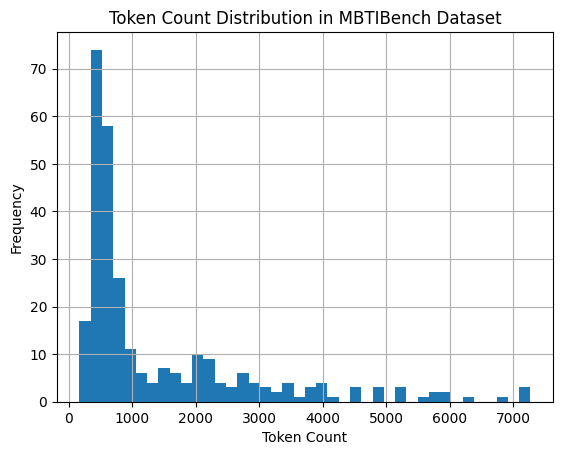

In [24]:
import matplotlib.pyplot as plt

df['token_count'].hist(bins=40)
plt.title("Token Count Distribution in MBTIBench Dataset")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

In [43]:
df_trunc = df[df['token_count'] < 1000]
df_trunc.shape

(183, 7)

In [26]:
import os
load_dotenv()
client = OpenAI(
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
)

In [27]:
from prompts import SYSTEM_PROMPT_MBTI_ANALYSIS

In [28]:
results = []

for row in tqdm(df_trunc.iterrows(), total=df_trunc.shape[0]):
    index, row = row
    posts_text = "\n".join(row["posts"])
    
    response = client.chat.completions.create(messages=[
        {
            "role": "system",
            "content": SYSTEM_PROMPT_MBTI_ANALYSIS
        },
        {
            "role": "user",
            "content": posts_text
        }
    ], model="google/gemini-2.0-flash-001", response_format={
                        "type": "json_object"
                    }, temperature=0.5, max_completion_tokens=2048)
    try:
        response = json.loads(response.choices[0].message.content)
        results.append(response)
    except Exception as e:
        print(e)
        print(response)
        results.append({
            "general_analysis": None,
            "introversion_extroversion_analysis": None,
            "introversion_extroversion_score": 0,
            "sensing_intuition_analysis": None,
            "sensing_intuition_score": 0,
            "thinking_feeling_analysis": None,
            "thinking_feeling_score": 0,
            "judging_perceiving_analysis": None,
            "judging_perceiving_score": 0,
            "predicted_mbti_type": None
        })

 15%|█▌        | 28/183 [01:42<14:51,  5.75s/it]

Unterminated string starting at: line 70 column 36 (char 9709)
ChatCompletion(id='gen-1741668822-zWUJMByb6LYHr1QBHbNZ', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content='[\n  {\n    "general_analysis": "This text expresses frustration with religious hypocrisy and a sense of isolation. The author critiques the selective morality of religious individuals and shares a brief, humorous anecdote. The overall tone is cynical and somewhat detached.",\n    "introversion_extroversion_analysis": "The text doesn\'t strongly indicate introversion or extroversion. The author expresses a personal opinion and shares a brief interaction, but it doesn\'t reveal a preference for internal reflection or external engagement. The humor is delivered in a concise manner, suggesting a possible preference for brevity in communication.",\n    "introversion_extroversion_score": "4",\n    "sensing_intuition_analysis": "The text leans slightly towards intuition. T

 51%|█████     | 93/183 [05:34<05:00,  3.34s/it]

Expecting ',' delimiter: line 3 column 250 (char 640)
ChatCompletion(id='gen-1741669062-4rKyagreQPmbzdPys1OR', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n  "general_analysis": "The text is a collection of short, informal thoughts and reactions, likely from social media. It covers a range of topics from anime and TV shows to personal experiences and humorous observations. The language is casual, with frequent use of slang, abbreviations, and emoticons. There\'s a mix of personal feelings, opinions on media, and interactions with others.",\n  "introversion_extroversion_analysis": "The text leans towards extroversion. There are frequent references to external stimuli like TV shows, anime, and interactions with others (\'i think those are shows isaac likes too\', \'big-sister nojiko from " one piece " joins the portrait of pirates series this april !\'). The author also shares personal experiences and reactions, suggesting a desi

 68%|██████▊   | 124/183 [07:20<03:29,  3.56s/it]

Expecting ',' delimiter: line 5 column 586 (char 1387)
ChatCompletion(id='gen-1741669167-xKgmkmTEBWPJcaieqAGz', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n  "general_analysis": "The text exhibits a stream-of-consciousness style, jumping between personal experiences, opinions, and interactions with others. There\'s a blend of humor, self-deprecation, and genuine empathy. The language is informal and conversational, suggesting a candid and expressive personality.",\n  "introversion_extroversion_analysis": "The text leans towards extroversion. The author frequently engages with others, responds to comments, and shares personal experiences openly. There are direct interactions and expressions of empathy, indicating a comfort with external engagement. Examples: \\"it\'s always a pleasure to see you,\\" \\":D i had a dream in which i went to russia to study russian poetry and also hack the game boy advance.\\"",\n  "introversion_ex

 94%|█████████▍| 172/183 [10:02<00:37,  3.44s/it]

Invalid \escape: line 7 column 120 (char 1649)
ChatCompletion(id='gen-1741669329-2LYPenr8x6GLJWEqmzye', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n  "general_analysis": "The text exhibits a highly extroverted and emotionally expressive style. It includes frequent use of emoticons, interjections, and references to shared experiences and social activities. There\'s a strong focus on immediate reactions and personal feelings, suggesting a preference for feeling over thinking. The content is diverse and spontaneous, indicative of a perceiving orientation. The text also shows a tendency to focus on the present and immediate future, rather than abstract concepts or long-term planning.",\n  "introversion_extroversion_analysis": "The text heavily leans towards extroversion. It includes numerous direct addresses to others (\'you\'), mentions of social activities (\'partay\', \'nachos at matador\'), and expressions of excitement and sh

100%|██████████| 183/183 [10:38<00:00,  3.49s/it]


In [44]:
# First, let's make sure all items in the results list are dictionaries
normalized_results = []
for item in results:
    if isinstance(item, list):
        # If the item is a list, we need to pick the first element if it exists
        # or create an empty dict if the list is empty
        if len(item) > 0:
            normalized_results.append(item[0])
        else:
            normalized_results.append({})
    else:
        # If it's already a dictionary, just add it
        normalized_results.append(item)

# Now create the DataFrame from the normalized data
results_df = pd.DataFrame(normalized_results)

# Concatenate results_df to df_trunc
df_trunc = pd.concat([df_trunc.reset_index(drop=True), results_df.reset_index(drop=True)], axis=1)

df_trunc.head()

,id,source,annotation,posts,softlabels,hardlabels,token_count,general_analysis,introversion_extroversion_analysis,introversion_extroversion_score,sensing_intuition_analysis,sensing_intuition_score,thinking_feeling_analysis,thinking_feeling_score,judging_perceiving_analysis,judging_perceiving_score,predicted_mbti_type
0,1,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...",[think that all these situations depend on who...,"{'E/I': 0.806772908366533, 'S/N': 0.1107266435...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'J'}",343,The text exhibits a blend of personal reflecti...,The text leans towards extroversion. The autho...,7,The text leans towards sensing. The author gro...,4,The text leans strongly towards feeling. The a...,2,The text leans towards perceiving. While the a...,7,ESFP
1,2,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...",[although I did get a PS1 and 2 and Box360 alo...,"{'E/I': 0.806772908366533, 'S/N': 0.0484429065...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'P'}",453,The text exhibits a mix of personal preference...,The text leans slightly towards introversion d...,4,The text shows a blend of sensing and intuitio...,6,The text leans towards feeling due to its emot...,7,The text leans towards perceiving due to its o...,7,INFP
2,3,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...","[dramatic, moving , . do; it's the single h...","{'E/I': 0.806772908366533, 'S/N': 0.4411764705...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'J'}",635,"The document contains a collection of short, d...",The text shows a moderate tendency towards ext...,6,The text leans slightly towards sensing. There...,4,The text exhibits a moderate balance between t...,5,The text leans towards perceiving. There is a ...,7,ESFP
3,4,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I+', 'A3': 'I-'}, ...",[are quite good but i don t like what they do ...,"{'E/I': 0.940239043824701, 'S/N': 0.4204152249...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'J'}",570,"The text exhibits a mix of cynicism, personal ...",The text leans slightly towards introversion. ...,4,The text shows a mix of sensing and intuition....,5,The text leans strongly towards thinking. The ...,2,The text leans towards judging. The author exp...,3,ISTJ
4,5,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...","[I am a 14 year old boy, and a high school fre...","{'E/I': 0.806772908366533, 'S/N': 0.4567474048...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'F', 'J/P': 'J'}",717,"The text is written by a young male, likely a ...",The text leans slightly towards extroversion. ...,6,The text is strongly rooted in sensing. The au...,2,The text shows a blend of thinking and feeling...,4,The text leans towards perceiving. The author ...,7,ISFP


In [45]:
score_columns = [col for col in df_trunc.columns if col.endswith('score')]
df_trunc[score_columns] = df_trunc[score_columns].astype(int)
df_trunc[score_columns] = df_trunc[score_columns] / 10
df_trunc.head()

,id,source,annotation,posts,softlabels,hardlabels,token_count,general_analysis,introversion_extroversion_analysis,introversion_extroversion_score,sensing_intuition_analysis,sensing_intuition_score,thinking_feeling_analysis,thinking_feeling_score,judging_perceiving_analysis,judging_perceiving_score,predicted_mbti_type
0,1,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...",[think that all these situations depend on who...,"{'E/I': 0.806772908366533, 'S/N': 0.1107266435...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'J'}",343,The text exhibits a blend of personal reflecti...,The text leans towards extroversion. The autho...,0.7,The text leans towards sensing. The author gro...,0.4,The text leans strongly towards feeling. The a...,0.2,The text leans towards perceiving. While the a...,0.7,ESFP
1,2,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...",[although I did get a PS1 and 2 and Box360 alo...,"{'E/I': 0.806772908366533, 'S/N': 0.0484429065...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'P'}",453,The text exhibits a mix of personal preference...,The text leans slightly towards introversion d...,0.4,The text shows a blend of sensing and intuitio...,0.6,The text leans towards feeling due to its emot...,0.7,The text leans towards perceiving due to its o...,0.7,INFP
2,3,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...","[dramatic, moving , . do; it's the single h...","{'E/I': 0.806772908366533, 'S/N': 0.4411764705...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'J'}",635,"The document contains a collection of short, d...",The text shows a moderate tendency towards ext...,0.6,The text leans slightly towards sensing. There...,0.4,The text exhibits a moderate balance between t...,0.5,The text leans towards perceiving. There is a ...,0.7,ESFP
3,4,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I+', 'A3': 'I-'}, ...",[are quite good but i don t like what they do ...,"{'E/I': 0.940239043824701, 'S/N': 0.4204152249...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'T', 'J/P': 'J'}",570,"The text exhibits a mix of cynicism, personal ...",The text leans slightly towards introversion. ...,0.4,The text shows a mix of sensing and intuition....,0.5,The text leans strongly towards thinking. The ...,0.2,The text leans towards judging. The author exp...,0.3,ISTJ
4,5,kaggle,"{'E/I': {'A1': 'I-', 'A2': 'I-', 'A3': 'I-'}, ...","[I am a 14 year old boy, and a high school fre...","{'E/I': 0.806772908366533, 'S/N': 0.4567474048...","{'E/I': 'I', 'S/N': 'S', 'T/F': 'F', 'J/P': 'J'}",717,"The text is written by a young male, likely a ...",The text leans slightly towards extroversion. ...,0.6,The text is strongly rooted in sensing. The au...,0.2,The text shows a blend of thinking and feeling...,0.4,The text leans towards perceiving. The author ...,0.7,ISFP


In [46]:
# swap things around to suit the way this was prompted
df_trunc["extroversion_introversion_score"] = 1 - df_trunc["introversion_extroversion_score"]


In [62]:
df_trunc.to_csv("data/mbtibench_with_scores_save.csv", index=False)

In [64]:
df_trunc = df_trunc[df_trunc.predicted_mbti_type.notnull()]
df_trunc = df_trunc[df_trunc["token_count"] > 50]

In [65]:
df_trunc.shape

(179, 18)

In [66]:
truth = {
    "ei": [],
    "sn": [],
    "tf": [],
    "jp": []
}

pred = {
    "ei": [],
    "sn": [],
    "tf": [],
    "jp": []
}

for index, row in df_trunc.iterrows():
    truth_data = row["softlabels"]
    truth["ei"].append(truth_data["E/I"])
    truth["sn"].append(truth_data["S/N"])
    truth["tf"].append(truth_data["T/F"])
    truth["jp"].append(truth_data["J/P"])

    pred["ei"].append(row["extroversion_introversion_score"])
    pred["sn"].append(row["sensing_intuition_score"])
    pred["tf"].append(row["thinking_feeling_score"])
    pred["jp"].append(row["judging_perceiving_score"])


In [67]:
truth_means = {
    "ei": np.mean(truth["ei"]),
    "sn": np.mean(truth["sn"]),
    "tf": np.mean(truth["tf"]),
    "jp": np.mean(truth["jp"])
}

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Calculate RMSE and MAE for each dimension
rmse_baseline = {}
mae_baseline = {}

rmse_model = {}
mae_model = {}

for dimension in truth_means.keys():
    y_true = np.array(truth[dimension])
    y_pred_baseline = np.array([truth_means[dimension]] * len(y_true))
    y_pred_model = np.array(pred[dimension])

    pred_valid = np.where(y_pred_model > 0)

    print("Excluding: ", len(y_pred_model) - np.count_nonzero(y_pred_model))

    y_true = y_true[pred_valid]
    y_pred_baseline = y_pred_baseline[pred_valid]
    y_pred_model = y_pred_model[pred_valid]
    
    rmse_baseline[dimension] = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
    mae_baseline[dimension] = mean_absolute_error(y_true, y_pred_baseline)

    rmse_model[dimension] = np.sqrt(mean_squared_error(y_true, y_pred_model))
    mae_model[dimension] = mean_absolute_error(y_true, y_pred_model)

print("Baseline RMSE:", rmse_baseline)
print("Baseline MAE:", mae_baseline)

print("Model RMSE:", rmse_model)
print("Model MAE:", mae_model)

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    "Dimension": truth_means.keys(),
    "Baseline RMSE": rmse_baseline.values(),
    "Baseline MAE": mae_baseline.values(),
    "Model RMSE": rmse_model.values(),
    "Model MAE": mae_model.values()
})

print(metrics_df)

Excluding:  0
Excluding:  0
Excluding:  0
Excluding:  0
Baseline RMSE: {'ei': 0.2945166023554, 'sn': 0.29358148986514443, 'tf': 0.3073044838480901, 'jp': 0.32436601447790536}
Baseline MAE: {'ei': 0.25455207271789587, 'sn': 0.25152721172883047, 'tf': 0.26394699778085395, 'jp': 0.2860771188373727}
Model RMSE: {'ei': 0.31597684236625756, 'sn': 0.305633026754474, 'tf': 0.37985320491187646, 'jp': 0.33889197605188515}
Model MAE: {'ei': 0.25453458445654076, 'sn': 0.24542480243075643, 'tf': 0.3116983975456085, 'jp': 0.29148671315445857}
  Dimension  Baseline RMSE  Baseline MAE  Model RMSE  Model MAE
0        ei       0.294517      0.254552    0.315977   0.254535
1        sn       0.293581      0.251527    0.305633   0.245425
2        tf       0.307304      0.263947    0.379853   0.311698
3        jp       0.324366      0.286077    0.338892   0.291487


In [69]:
class_accuracy = {
    "E/I": [],
    "S/N": [],
    "T/F": [],
    "J/P": []
}

off_by = []

for index, row in df_trunc.iterrows():
    hardlabels = row["hardlabels"]
    pred_mbti = row["predicted_mbti_type"]
    if not pred_mbti:
        continue

    row_off_by = 0

    for dim_idx, dimension in enumerate(class_accuracy.keys()):
        if hardlabels[dimension] == pred_mbti[dim_idx]:
            class_accuracy[dimension].append(1)
        else:
            class_accuracy[dimension].append(0)
            row_off_by += 1
    
    off_by.append(row_off_by)

In [74]:
# Calculate the percentage of rows that are only off by 0 or 1
off_by_0_or_1 = [x for x in off_by if x <= 1]
percentage_off_by_0_or_1 = (len(off_by_0_or_1) / len(off_by)) * 100

print(f"Percentage of rows that are only off by 0 or 1: {percentage_off_by_0_or_1:.2f}%")

Percentage of rows that are only off by 0 or 1: 49.72%


In [72]:
accuracy = {}

for dimension in class_accuracy.keys():
    accuracy[dimension] = np.mean(class_accuracy[dimension])

print(accuracy)

{'E/I': 0.6201117318435754, 'S/N': 0.6033519553072626, 'T/F': 0.659217877094972, 'J/P': 0.5698324022346368}
